In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
import scipy.linalg
from numpy.linalg import inv
import scienceplots
# import warnings

# warnings.filterwarnings("ignore")

plt.style.use(['ggplot', 'notebook', 'grid'])


In [2]:
# Function that stores the slicing

def slicing(data, index, axis):
    if axis == 'x':
        return data[index, :, :]
    elif axis == 'y':
        return data[:, index, :]
    elif axis == 'z':
        return data[:, :, index]
    else:
        print("Axis must be 0, 1 or 2")
        return None

In [3]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [4]:
import os

if os.path.exists("J:\\Universidade\\IC\\Amplitude\\model0.npy"):
    data_amp = np.load("J:\\Universidade\\IC\\Amplitude\\model0.npy")
else:
    data_amp = np.load("F:\\Universidade\\IC\\Amplitude\\model0.npy")
if os.path.exists("J:\\Universidade\\IC\\Faults\\model0.npy"):
    data_faults = np.load("J:\\Universidade\\IC\\Faults\\model0.npy")
else:
    data_faults = np.load("F:\\Universidade\\IC\\Faults\\model0.npy")
if os.path.exists("J:\\Universidade\\IC\\Impedance\\model0.npy"):
    data_imp = np.load("J:\\Universidade\\IC\\Impedance\\model0.npy")
else:
    data_imp = np.load("F:\\Universidade\\IC\\Impedance\\model0.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_faults)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)
 data shape (256, 256, 256)


taxa de amostragem frequencia de nyquist?

Correlação pearson

Gerando a wavelet de Ricker

In [5]:
def ricker(peak_freq, samples, dt):
    # Calculate time array
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Calculate Ricker wavelet
    pi2_f2_t2 = (np.pi**2) * (peak_freq**2) * (t**2)
    ricker = (1. - 2. * pi2_f2_t2) * np.exp(-pi2_f2_t2)

    return t, ricker

twlet, wlet = ricker(peak_freq=30, samples=36, dt=4)          # wavelet
freqs = np.fft.rfftfreq(twlet.shape[0], d=4/1000)
fft = np.abs(np.fft.rfft(wlet)) * 0.30

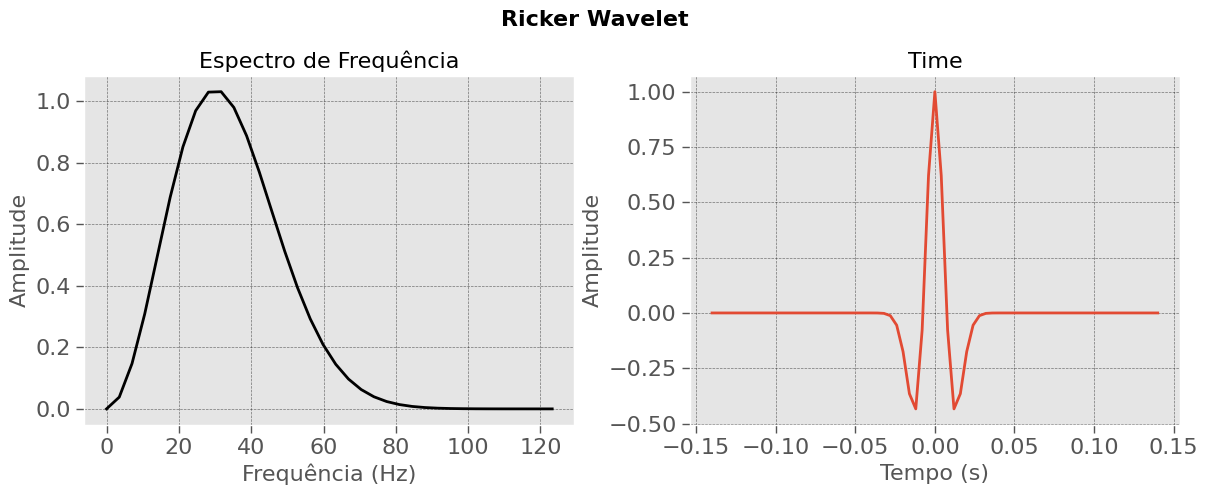

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Ricker Wavelet', fontsize=16, fontweight='bold')

axs[0].plot(freqs, fft, color='black')
axs[0].set_title('Espectro de Frequência')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(twlet,wlet)
axs[1].set_title('Time')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [19]:
from scipy import signal

def butter_wavelet(freq_hi, freq_low, samples, dt):
    # Calculate time array
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Create impulse signal
    imp = signal.unit_impulse(t.shape[0], 'mid')

    # Apply high-pass Butterworth filter
    fs = 1000 * (1 / dt)
    b, a = signal.butter(4, freq_hi, fs=fs)
    response_zp = signal.filtfilt(b, a, imp)

    # Apply low-pass Butterworth filter
    low_b, low_a = signal.butter(2, freq_low, 'hp', fs=fs)
    butter_wvlt = signal.filtfilt(low_b, low_a, response_zp)

    return t, butter_wvlt

twlet_b, wlet_b = butter_wavelet(freq_hi=55, freq_low=10, samples=36, dt=4)          # wavelet
fft_b = abs(np.fft.rfft(wlet_b))
freqs_b = np.fft.rfftfreq(twlet_b.shape[0], d=4/1000)

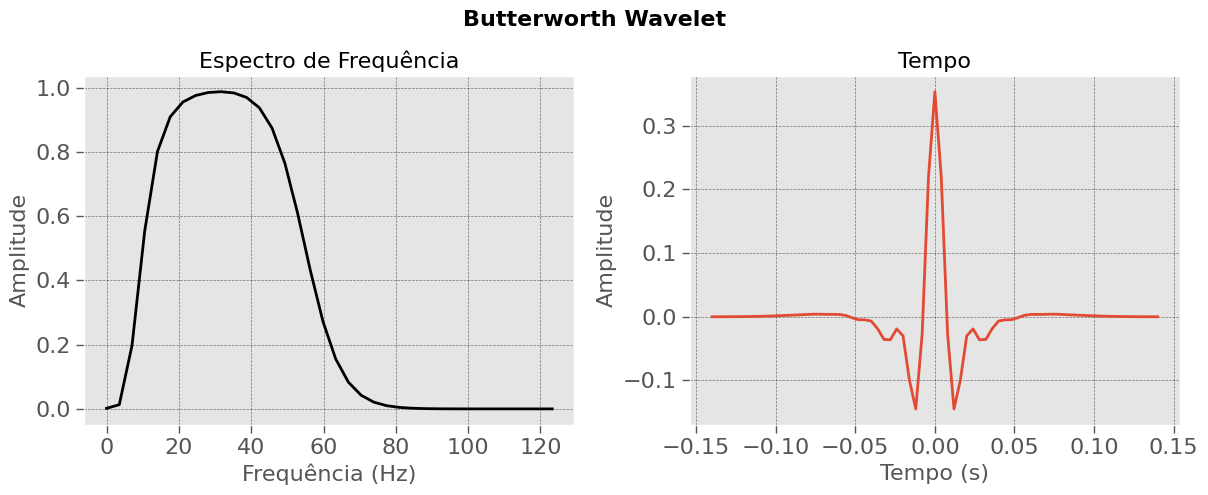

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Butterworth Wavelet', fontsize=16, fontweight='bold')

axs[0].plot(freqs_b, fft_b, color="black")
axs[0].set_title('Espectro de Frequência')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(twlet_b, wlet_b)
axs[1].set_title('Tempo')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

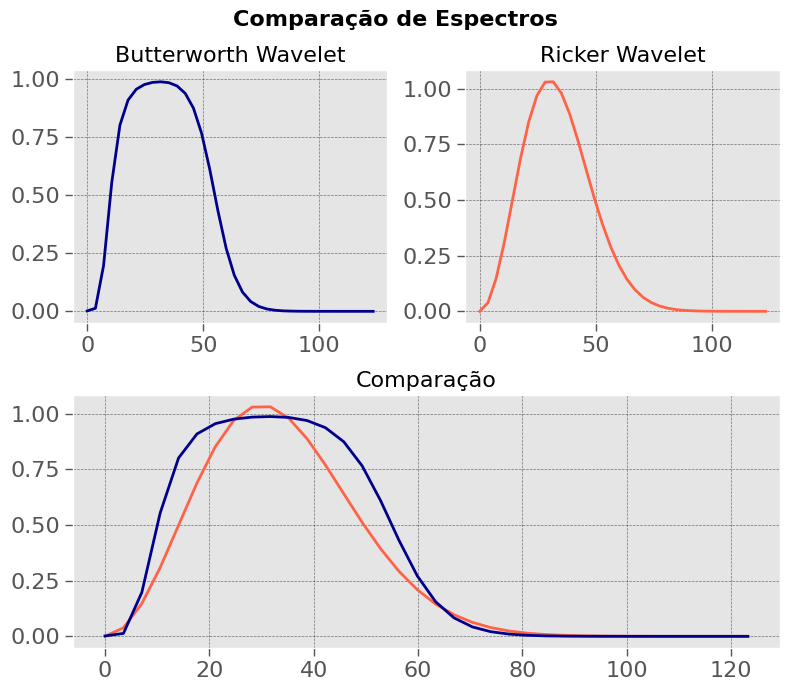

In [21]:
plt.figure(figsize=(8, 7))

plt.suptitle("Comparação de Espectros", fontsize=16, fontweight='bold')

plt.subplot2grid((2, 2), (0, 0))
plt.plot(freqs_b, fft_b, color="darkblue")
plt.title("Butterworth Wavelet")

plt.subplot2grid((2, 2), (0, 1))
plt.plot(freqs, fft, color="tomato")
plt.title("Ricker Wavelet")

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.plot(freqs, fft, color="tomato")
plt.plot(freqs_b, fft_b, color="darkblue")
plt.title("Comparação")

plt.tight_layout()
plt.show()

In [29]:
# Impedância de baixa

cutoff = 6
fs = 128

imp_background = butter_lowpass_filtfilt(data_imp, cutoff, fs, order=5)

C:\Users\aalbano\AppData\Local\Temp\ipykernel_10228\1099258418.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y


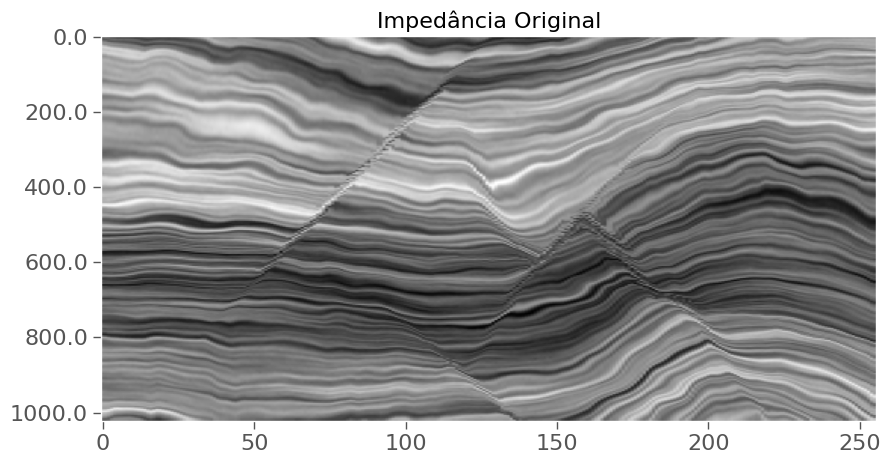

In [30]:
plt.figure(figsize=(10, 5))

plt.imshow(data_imp[100, :, :].T, cmap='gray', aspect='auto')
plt.title('Impedância Original')
plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y
plt.grid()


C:\Users\aalbano\AppData\Local\Temp\ipykernel_10228\290664220.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y
C:\Users\aalbano\AppData\Local\Temp\ipykernel_10228\290664220.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y


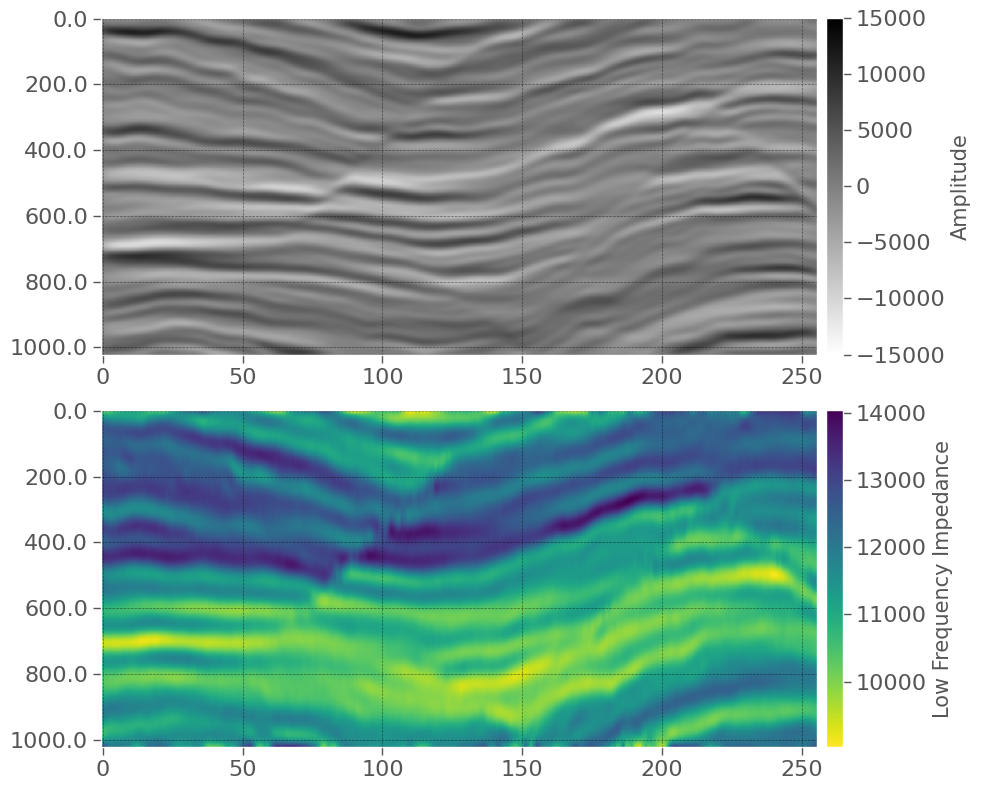

In [31]:
# Plot da impedância (gabarito)
plt.figure(figsize=(10,8))

plt.subplot(211)
c = plt.imshow(data_amp[150,:,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
plt.colorbar(c, pad=0.01).set_label('Amplitude', size=15)
plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y

plt.subplot(212)
c = plt.imshow(imp_background[150,:,:].T,
               cmap='viridis_r',
               aspect='auto',
               #vmin=8000,
               #vmax=14000
               )
plt.colorbar(c, pad=0.01).set_label('Low Frequency Impedance', size=15)
plt.gca().set_yticklabels(plt.gca().get_yticks() * 4)  # Altera os rótulos do eixo y

plt.tight_layout()
plt.show()

Se está pegando o nz, nx e ny. Fazendo um desenho:
A inversão ocorrerá nas seções nz e nx, ao longo de ny.

<img src="Figures/schematic.png" width=600 height=400>

Então, cada operador PPop precisa ser aplicado em cada seção nz e nx, até o número de ny.

In [32]:
# Parâmetros do operador
nz, nx, ny = data_amp.shape

# Wavelet operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wlet/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

PPop_b = pylops.avo.poststack.PoststackLinearModelling(wlet_b/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

## Sem regularização

In [45]:
# Ricker
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_section = \
        pylops.optimization.leastsquares.normal_equations_inversion(Op=PPop,
                                                                    y = seismic_section.flatten(),
                                                                    Regs=[],
                                                                    epsI=5e-1, #tikhonov
                                                                    x0 = impedance_section.flatten(), # modelo inicial
                                                                    engine='scipy',
                                                                    **dict(maxiter=1000))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance[:, :, iy] = inverted_impedance_section.reshape(nz, nx)

inverted_impedance_final = inverted_impedance + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa


# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance.npy', inverted_impedance)

In [42]:
# Butterworth
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_section = \
        pylops.optimization.leastsquares.normal_equations_inversion(Op=PPop_b,
                                                                    y = seismic_section.flatten(),
                                                                    Regs=[],
                                                                    epsI=5e-1, #tikhonov
                                                                    x0 = impedance_section.flatten(), # modelo inicial
                                                                    engine='scipy',
                                                                    **dict(maxiter=1000))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance[:, :, iy] = inverted_impedance_section.reshape(nz, nx)

inverted_impedance_final = inverted_impedance + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa


# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance.npy', inverted_impedance)

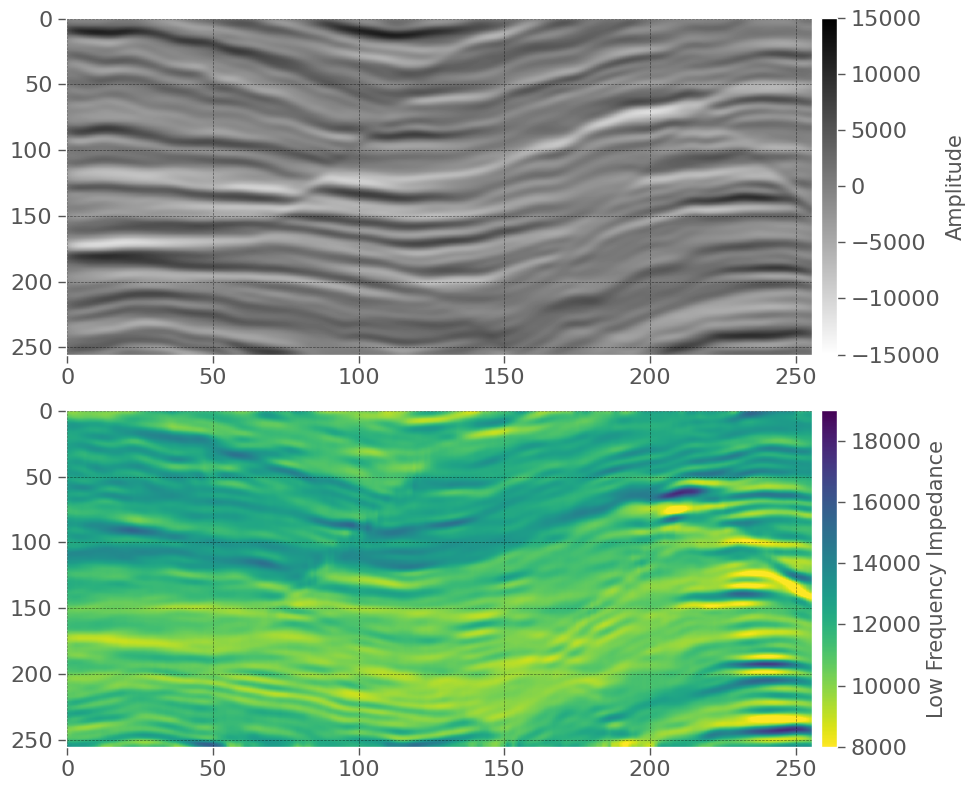

In [46]:
plt.figure(figsize=(10,8))

plt.subplot(211)
c = plt.imshow(data_amp[150,:,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
plt.colorbar(c, pad=0.01).set_label('Amplitude', size=15)

plt.subplot(212)
c = plt.imshow(inverted_impedance_final[150,:,:].T,
               cmap='viridis_r',
               aspect='auto',
               vmin=8000,
               vmax=19000
               )
plt.colorbar(c, pad=0.01).set_label('Low Frequency Impedance', size=15)

plt.tight_layout()
plt.show()

## Com regularização

In [34]:
D2op = pylops.SecondDerivative([nz, nx], axis=1, dtype='float64')

In [35]:

# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_regularized = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_regularized_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_regularized_section = \
        pylops.optimization.leastsquares.regularized_inversion(Op=PPop,
                                                               y = seismic_section.flatten(),
                                                               Regs=[D2op],
                                                               x0 = impedance_section.flatten(), # modelo inicial
                                                               **dict(damp=9e-1, iter_lim=1000, show=0))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_regularized[:, :, iy] = inverted_impedance_regularized_section.reshape(nz, nx)

# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance_regularized.npy', inverted_impedance_regularized)

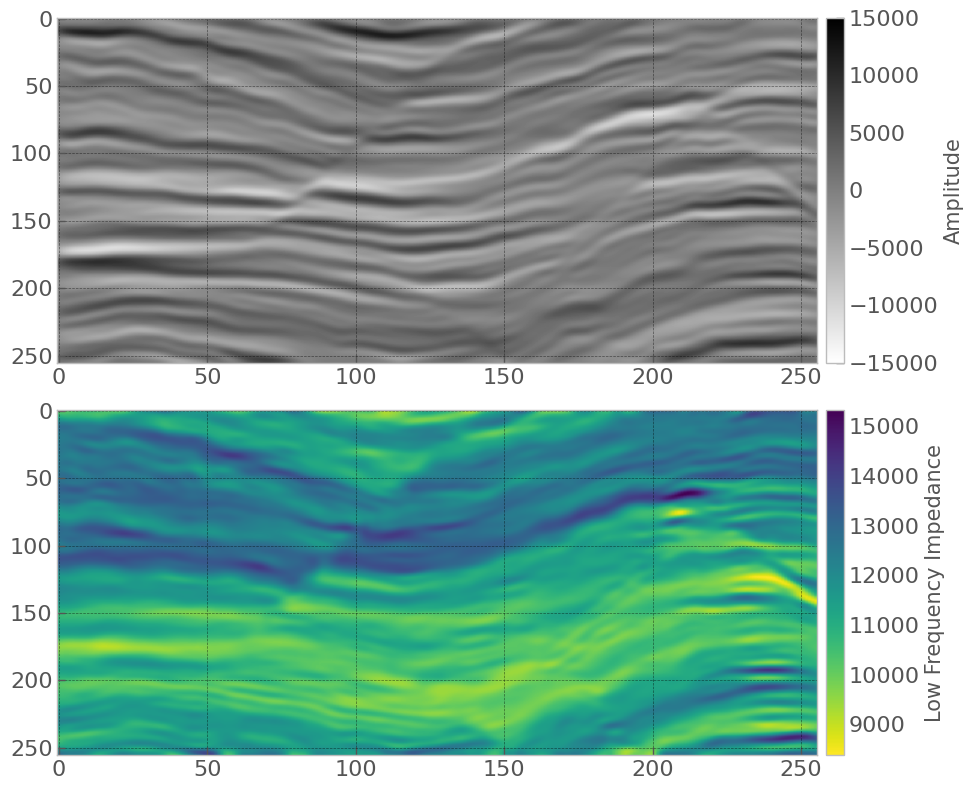

In [36]:
plt.figure(figsize=(10,8))

plt.subplot(211)
c = plt.imshow(data_amp[150,:,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
plt.colorbar(c, pad=0.01).set_label('Amplitude', size=15)

plt.subplot(212)
c = plt.imshow(inverted_impedance_regularized[150,:,:].T,
               cmap='viridis_r',
               aspect='auto',
            #    vmin=5000,
            #    vmax=10000
               )
plt.colorbar(c, pad=0.01).set_label('Low Frequency Impedance', size=15)

plt.tight_layout()
plt.show()

## FISTA

In [ ]:
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_FISTA = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = data_imp[:, :, iy]

    inverted_impedance_FISTA_section = \
        pylops.optimization.sparsity.fista(Op=PPop,
                                           y = seismic_section.flatten(),
                                           x0 = impedance_section.flatten(), # modelo inicial
                                           niter=1000,
                                           eps=5-1,
                                           tol=1e-1)[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_FISTA[:, :, iy] = inverted_impedance_FISTA_section.reshape(nz, nx)

# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance_FISTA.npy', inverted_impedance_FISTA)

In [ ]:
# minimos quadrados sem regularização
plt.imshow(inverted_impedance_FISTA[25,:,:].T, aspect='auto', cmap='gray_r')
plt.colorbar()